In [2]:
!pip install skforecast

Defaulting to user installation because normal site-packages is not writeable
  Using cached skforecast-0.6.0-py2.py3-none-any.whl (216 kB)
  Using cached optuna-3.0.5-py3-none-any.whl (348 kB)
  Using cached scikit_optimize-0.9.0-py2.py3-none-any.whl (100 kB)
  Using cached pyaml-21.10.1-py2.py3-none-any.whl (24 kB)
  Using cached cmaes-0.9.1-py3-none-any.whl (21 kB)
     ---------------------------------------- 36.9/36.9 MB 3.9 MB/s eta 0:00:00
  Using cached alembic-1.9.4-py3-none-any.whl (210 kB)
  Using cached cliff-4.2.0-py3-none-any.whl (81 kB)
  Using cached colorlog-6.7.0-py2.py3-none-any.whl (11 kB)
  Using cached Mako-1.2.4-py3-none-any.whl (78 kB)
  Using cached prettytable-3.6.0-py3-none-any.whl (27 kB)
  Using cached autopage-0.5.1-py3-none-any.whl (29 kB)
  Using cached stevedore-5.0.0-py3-none-any.whl (49 kB)
  Using cached cmd2-2.4.3-py3-none-any.whl (147 kB)
  Using cached pyperclip-1.8.2.tar.gz (20 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (se

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from  matplotlib import pyplot
from datetime import date
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from datetime import timedelta 

In [3]:
df = pd.read_csv("series.csv")

In [4]:
df.shape

(2686, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CATEGORY    2686 non-null   object
 1   DATE        2686 non-null   object
 2   UNITS_SOLD  2686 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 63.1+ KB


In [6]:
df['DATE']= pd.to_datetime(df['DATE'],format="%Y-%m-%d")

In [7]:
df.head()

,CATEGORY,DATE,UNITS_SOLD
0,CATEG-1,2021-08-17,59
1,CATEG-1,2020-09-19,40
2,CATEG-2,2021-10-26,23
3,CATEG-1,2021-04-27,60
4,CATEG-2,2021-05-05,61


In [8]:
df.groupby('CATEGORY').describe()

UNITS_SOLD                                                       \
              count         mean         std  min    25%     50%     75%   
CATEGORY                                                                   
CATEG-1       887.0    53.130778   31.921476  1.0   31.0    47.0    65.0   
CATEG-2       879.0    44.747440   59.467396  1.0    9.0    19.0    51.5   
CATEG-3       920.0  1457.304348  869.635335  0.0  675.0  1452.0  2015.0   

                  
             max  
CATEGORY          
CATEG-1    210.0  
CATEG-2    332.0  
CATEG-3   7551.0

In [9]:
df.groupby('CATEGORY').DATE.agg(['min','max'])

,min,max
CATEGORY,,
CATEG-1,2018-10-16,2021-11-12
CATEG-2,2018-10-16,2021-11-12
CATEG-3,2018-09-24,2021-11-12


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CATEGORY    2686 non-null   object        
 1   DATE        2686 non-null   datetime64[ns]
 2   UNITS_SOLD  2686 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 63.1+ KB


In [11]:
df.set_index('DATE',inplace=True,drop=True)
df['UNITS_SOLD']= df['UNITS_SOLD'].astype(np.int32)

In [12]:
df_1 = df[df.CATEGORY=='CATEG-1'][['UNITS_SOLD']]
df_2 = df[df.CATEGORY=='CATEG-2'][['UNITS_SOLD']]
df_3 = df[df.CATEGORY=='CATEG-3'][['UNITS_SOLD']]

### CATEG-1

In [12]:
df_1 = df_1.sort_index(ascending=True)

In [13]:
df_1.shape

(887, 1)

In [14]:
df_1.head(10)

,UNITS_SOLD
DATE,
2018-10-16,1
2019-06-11,27
2019-06-12,26
2019-06-13,24
2019-06-14,18
2019-06-15,15
2019-06-16,11
2019-06-17,22
2019-06-18,19


In [15]:
df_1.tail(10)

,UNITS_SOLD
DATE,
2021-11-03,36
2021-11-04,52
2021-11-05,62
2021-11-06,54
2021-11-07,46
2021-11-08,63
2021-11-09,65
2021-11-10,189
2021-11-11,194


Como podemos ver en las 10 primeras observaciones de la serie, hay una observación del 2018-10-16 y puego la serie sigue diaria despues del 2019-06-11, luego quitamos la primera observación.

In [16]:
df_1 = df_1.loc['2019-06-11':'2021-11-12']
df_1.shape

(886, 1)

In [17]:
df_1.set_index(df_1.resample('D').mean().index,inplace=True,drop=True)

Comprobamos que la longitud de la serie coincida con la cantidad de dias entre las fechas de inicio y final de la misma

In [18]:
f_date = date(2019, 6, 11)
l_date = date(2021, 11, 12)
delta = l_date - f_date
print(delta.days)

885


Graficamos la serie para evidenciar estacionalidades

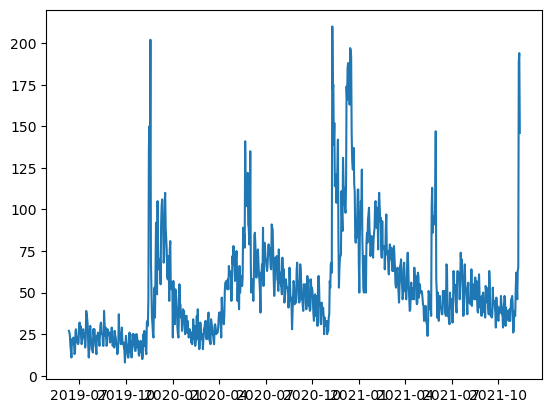

In [19]:
plt.plot(df_1.UNITS_SOLD)

Graficamos la primera de la serie y parece quedar con una media constante pero la varianza no lo es

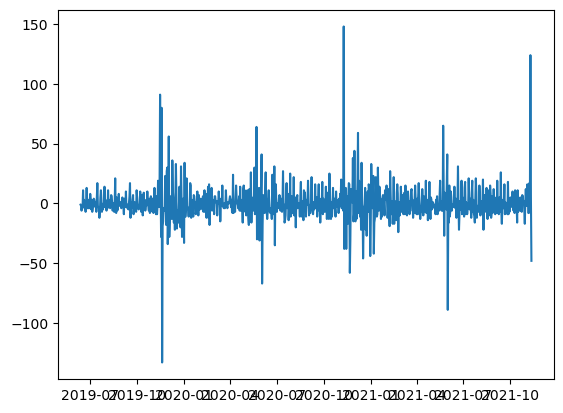

In [20]:
plt.plot(df_1.UNITS_SOLD-df_1.UNITS_SOLD.shift(1))

Graficamos el autocorrelograma y el autocorrelograma parcial para identificar si es un proceso ARMA

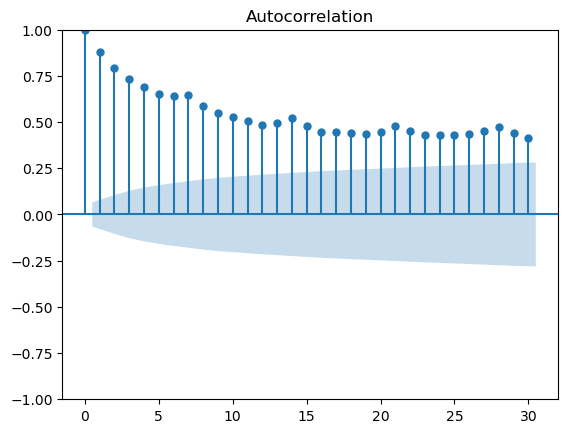

In [22]:
plot_acf(df_1)
pyplot.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


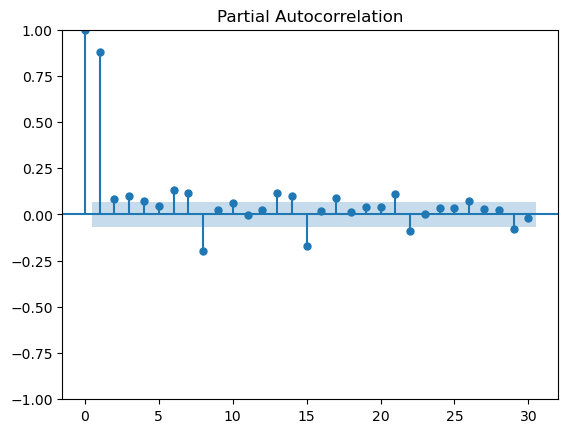

In [23]:
plot_pacf(df_1, lags=30)
pyplot.show()

Hacemos la partición de la serie, para estimar los ultimos 120 dias

Train dates : 2019-06-11 00:00:00 --- 2021-07-15 00:00:00  (n=766)
Test dates  : 2021-07-16 00:00:00 --- 2021-11-12 00:00:00  (n=120)


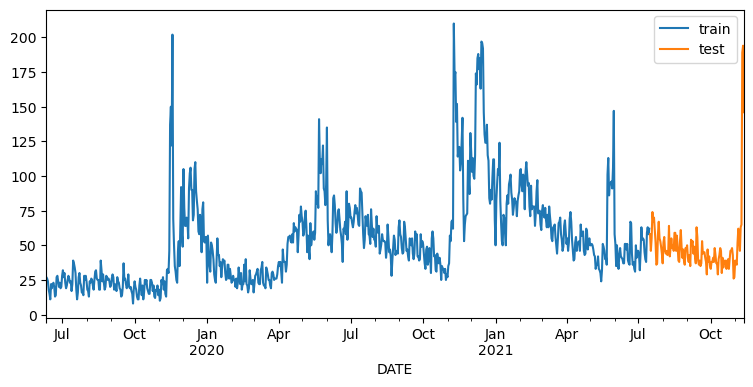

In [21]:
steps = 120
data_train = df_1[:-steps]
data_test  = df_1[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['UNITS_SOLD'].plot(ax=ax, label='train')
data_test['UNITS_SOLD'].plot(ax=ax, label='test')
ax.legend();

Según lo que vimos anteriormente se necesita 1 diferencia para que el proceso se aproxime a ser estacionario y según los autocorrelogramas vemos que es un proceso aurotegresivo. En las graficas se ve que mas o menos cada 6 meses hay unos picos, luego ajustamos la estacionalidad a 180 dias.

In [23]:
SARIMAmodel = SARIMAX(data_train, order = (1, 1, 0), seasonal_order=(1,1,0,180)) 
SARIMAmodel = SARIMAmodel.fit()

Hacemos el predict sobre los 120 dias que definimos anteriormente + 21 dias adicionales que son las predicciones solicitadas.

In [34]:
y_pred = SARIMAmodel.get_forecast(len(data_test.index)+21)
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred = SARIMAmodel.get_forecast(len(data_test.index)+21)
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1]+ timedelta(days=21))
#y_pred_df.index = data_test.index
y_pred_out = y_pred_df["Predictions"]

In [33]:
y_pred_df

,lower UNITS_SOLD,upper UNITS_SOLD,Predictions
2021-07-16,22.881641,94.645541,58.763591
2021-07-17,16.130793,108.683105,62.406949
2021-07-18,13.020763,123.821643,68.421203
2021-07-19,-1.355479,124.866793,61.755657
2021-07-20,-14.134534,125.856861,55.861163
...,...,...,...
2021-11-29,-288.476558,420.913397,66.218419
2021-11-30,-297.477866,414.489846,58.505990
2021-12-01,-282.578156,431.958014,74.689929
2021-12-02,-253.419930,463.675498,105.127784


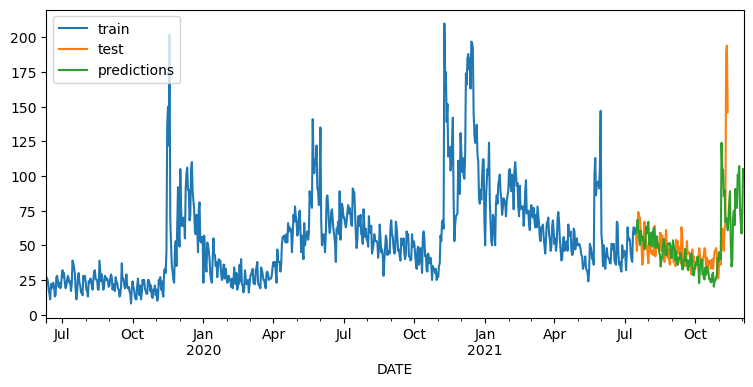

In [35]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train['UNITS_SOLD'].plot(ax=ax, label='train')
data_test['UNITS_SOLD'].plot(ax=ax, label='test')
y_pred_out.plot(ax=ax, label='predictions')
ax.legend();

In [38]:
arma_rmse = np.sqrt(mean_squared_error(data_test["UNITS_SOLD"].values, y_pred_df[y_pred_df.index.isin(data_test.index)]["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  23.307790469429367


### CATEG-2

In [13]:
df_2 = df_2.sort_index(ascending=True)

In [14]:
df_2.shape

(879, 1)

In [15]:
df_2.head(10)

,UNITS_SOLD
DATE,
2018-10-16,1
2019-06-11,15
2019-06-12,13
2019-06-13,8
2019-06-14,9
2019-06-15,9
2019-06-16,7
2019-06-17,15
2019-06-18,17


In [16]:
df_2.tail(10)

,UNITS_SOLD
DATE,
2021-11-03,17
2021-11-04,14
2021-11-05,18
2021-11-06,17
2021-11-07,13
2021-11-08,21
2021-11-09,13
2021-11-10,18
2021-11-11,20


In [17]:
df_2 = df_2.loc['2019-06-11':'2021-11-12']
df_2.shape

(878, 1)

Hay 8 dias que no estan en la serie,entonces los vamos a añadir con el valor de NA

In [18]:
dias_faltan = sorted(list(set(df_2.resample('D').mean().index) - set(df_2.index)))
dias_faltan

[Timestamp('2019-08-14 00:00:00', freq='D'),
 Timestamp('2019-08-15 00:00:00', freq='D'),
 Timestamp('2019-08-16 00:00:00', freq='D'),
 Timestamp('2019-08-17 00:00:00', freq='D'),
 Timestamp('2019-08-18 00:00:00', freq='D'),
 Timestamp('2019-08-19 00:00:00', freq='D'),
 Timestamp('2019-08-20 00:00:00', freq='D'),
 Timestamp('2019-10-26 00:00:00', freq='D')]

In [19]:
add_days = pd.Series([np.nan]*len(dias_faltan), index = dias_faltan).to_frame()
add_days.rename(columns={0: 'UNITS_SOLD'})
df_2= pd.concat([df_2,add_days])
df_2 = df_2[['UNITS_SOLD']]
df_2 = df_2.sort_index(ascending=True)

In [20]:
df_2.set_index(df_2.resample('D').mean().index,inplace=True,drop=True)

Comprobamos que la longitud de la serie coincida con la cantidad de dias entre las fechas de inicio y final de la misma

In [21]:
f_date = date(2019, 6, 11)
l_date = date(2021, 11, 12)
delta = l_date - f_date
print(delta.days)

885


In [22]:
df_2.shape

(886, 1)

In [23]:
#df_2 = df_2.loc['2019-10-27':'2021-11-12']

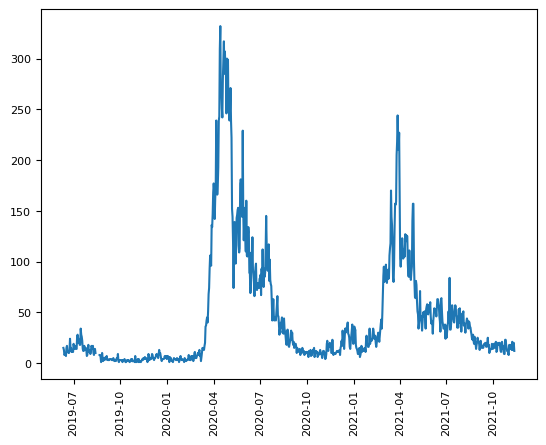

In [24]:
plt.rcParams['font.size'] = '8'
plt.xticks(rotation=90)
plt.plot(df_2.UNITS_SOLD)

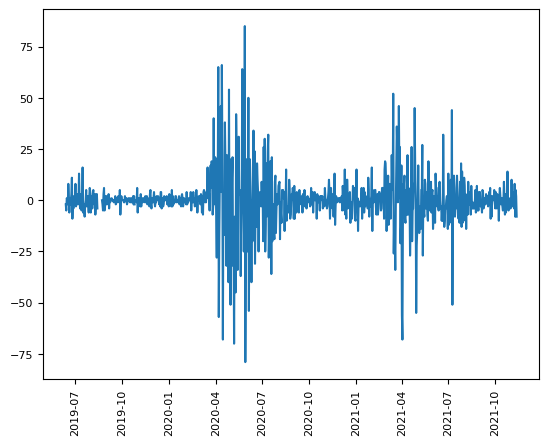

In [25]:
plt.rcParams['font.size'] = '8'
plt.xticks(rotation=90)
plt.plot(df_2.UNITS_SOLD-df_2.UNITS_SOLD.shift(1))

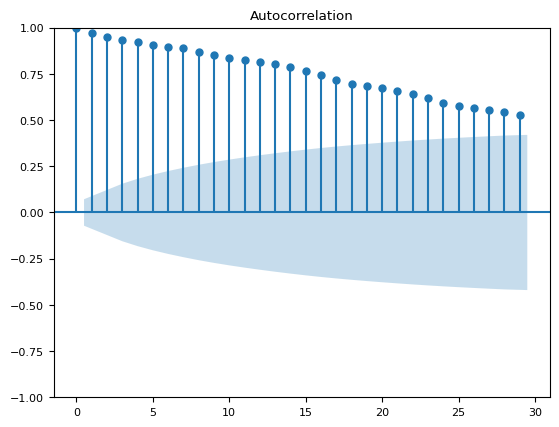

In [26]:
plot_acf(df_2.loc['2019-10-27':'2021-11-12'])
pyplot.show()

C:\Users\Camila Bermudez\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


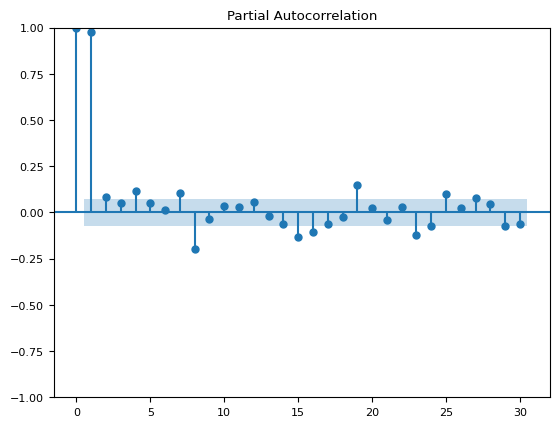

In [27]:
plot_pacf(df_2.loc['2019-10-27':'2021-11-12'], lags=30)
pyplot.show()

Train dates : 2019-06-11 00:00:00 --- 2021-07-15 00:00:00  (n=766)
Test dates  : 2021-07-16 00:00:00 --- 2021-11-12 00:00:00  (n=120)


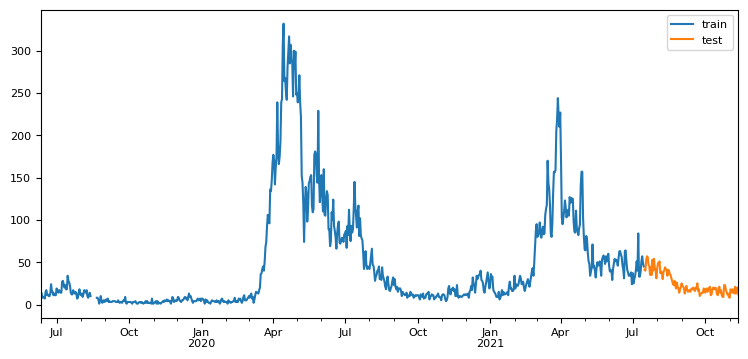

In [28]:
steps = 120
data_train = df_2[:-steps]
data_test  = df_2[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['UNITS_SOLD'].plot(ax=ax, label='train')
data_test['UNITS_SOLD'].plot(ax=ax, label='test')
ax.legend();

In [ ]:
SARIMAmodel = SARIMAX(data_train, order = (1, 1, 0),seasonal_order=(1,1,0,360))
SARIMAmodel = SARIMAmodel.fit()

In [35]:
y_pred = SARIMAmodel.get_forecast(len(data_test.index)+21)
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred = SARIMAmodel.get_forecast(len(data_test.index)+21)
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1]+ timedelta(days=21))
#y_pred_df.index = data_test.index
y_pred_out = y_pred_df["Predictions"]

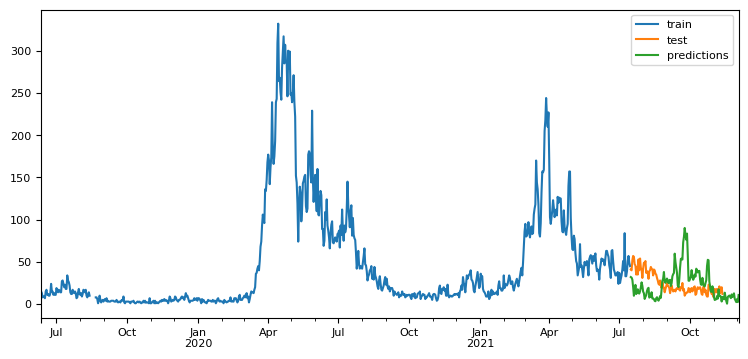

In [36]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train['UNITS_SOLD'].plot(ax=ax, label='train')
data_test['UNITS_SOLD'].plot(ax=ax, label='test')
y_pred_out.plot(ax=ax, label='predictions')
ax.legend();

In [37]:
arma_rmse = np.sqrt(mean_squared_error(data_test["UNITS_SOLD"].values, y_pred_df[y_pred_df.index.isin(data_test.index)]["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  26.23836558849234


### CATEG-3

In [87]:
df_3 = df_3.sort_index(ascending=True)

In [88]:
df_3.shape

(920, 1)

In [89]:
df_3.head(10)

,UNITS_SOLD
DATE,
2018-09-24,0
2018-09-25,0
2018-09-27,0
2018-09-28,2
2018-09-29,1
2018-09-30,1
2018-10-01,2
2018-10-02,1
2018-10-03,2


In [90]:
df_3.tail(10)

,UNITS_SOLD
DATE,
2021-11-03,2065
2021-11-04,2618
2021-11-05,2929
2021-11-06,2751
2021-11-07,2576
2021-11-08,2812
2021-11-09,2894
2021-11-10,7551
2021-11-11,6294


In [91]:
dias_faltan = sorted(list(set(df_3.resample('D').mean().index) - set(df_3.index)))
dias_faltan

[Timestamp('2018-09-26 00:00:00', freq='D'),
 Timestamp('2018-10-16 00:00:00', freq='D'),
 Timestamp('2018-10-17 00:00:00', freq='D'),
 Timestamp('2018-10-26 00:00:00', freq='D'),
 Timestamp('2018-10-27 00:00:00', freq='D'),
 Timestamp('2018-10-28 00:00:00', freq='D'),
 Timestamp('2018-10-30 00:00:00', freq='D'),
 Timestamp('2018-10-31 00:00:00', freq='D'),
 Timestamp('2018-11-01 00:00:00', freq='D'),
 Timestamp('2018-11-02 00:00:00', freq='D'),
 Timestamp('2018-11-04 00:00:00', freq='D'),
 Timestamp('2018-11-06 00:00:00', freq='D'),
 Timestamp('2018-11-07 00:00:00', freq='D'),
 Timestamp('2018-11-09 00:00:00', freq='D'),
 Timestamp('2018-11-10 00:00:00', freq='D'),
 Timestamp('2018-11-12 00:00:00', freq='D'),
 Timestamp('2018-11-13 00:00:00', freq='D'),
 Timestamp('2018-11-14 00:00:00', freq='D'),
 Timestamp('2018-11-15 00:00:00', freq='D'),
 Timestamp('2018-11-16 00:00:00', freq='D'),
 Timestamp('2018-11-17 00:00:00', freq='D'),
 Timestamp('2018-11-18 00:00:00', freq='D'),
 Timestamp

In [92]:
len(dias_faltan)

226

In [93]:
df_3 = df_3.loc['2018-09-24':'2021-11-12']
df_3.shape

(920, 1)

In [94]:
add_days = pd.Series([np.nan]*len(dias_faltan), index = dias_faltan).to_frame()
add_days.rename(columns={0: 'UNITS_SOLD'})
df_3= pd.concat([df_3,add_days])
df_3 = df_3[['UNITS_SOLD']]
df_3 = df_3.sort_index(ascending=True)

In [95]:
df_3.set_index(df_3.resample('D').mean().index,inplace=True,drop=True)

In [96]:
f_date = date(2018, 9, 24)
l_date = date(2021, 11, 12)
delta = l_date - f_date
print(delta.days)

1145


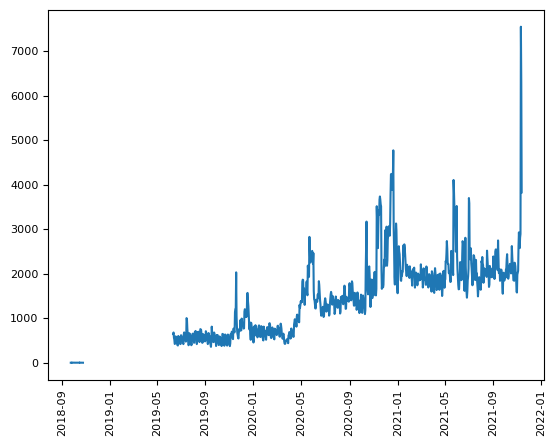

In [97]:
plt.rcParams['font.size'] = '8'
plt.xticks(rotation=90)
plt.plot(df_3.UNITS_SOLD)

In [98]:
df_3 = df_3.loc['2019-06-11':'2021-11-12']
df_3.shape

(886, 1)

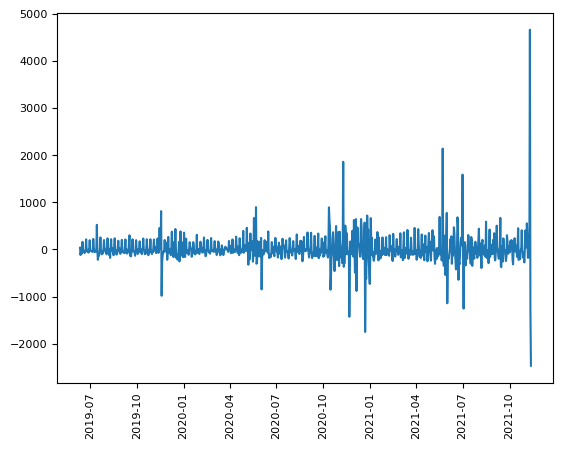

In [100]:
plt.rcParams['font.size'] = '8'
plt.xticks(rotation=90)
plt.plot(df_3.UNITS_SOLD-df_3.UNITS_SOLD.shift(1))

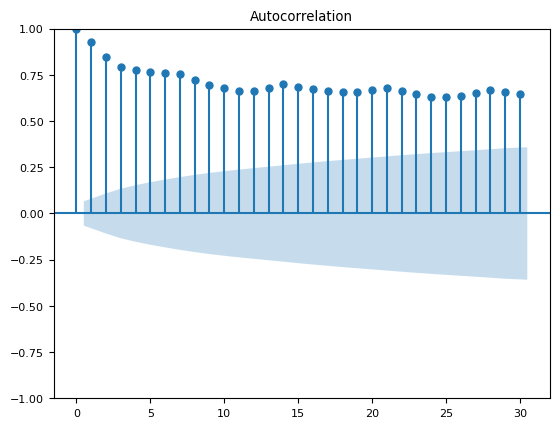

In [101]:
plot_acf(df_3)
pyplot.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


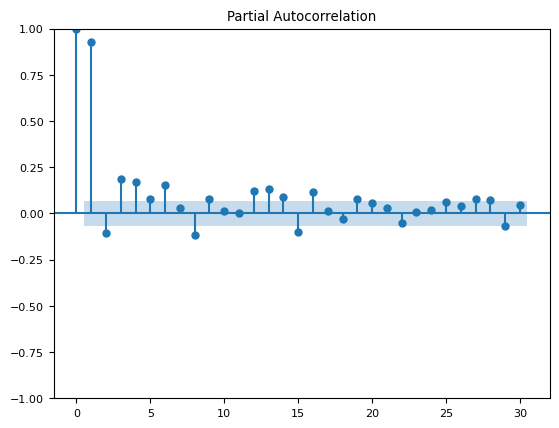

In [102]:
plot_pacf(df_3, lags=30)
pyplot.show()

Train dates : 2019-06-11 00:00:00 --- 2021-07-15 00:00:00  (n=766)
Test dates  : 2021-07-16 00:00:00 --- 2021-11-12 00:00:00  (n=120)


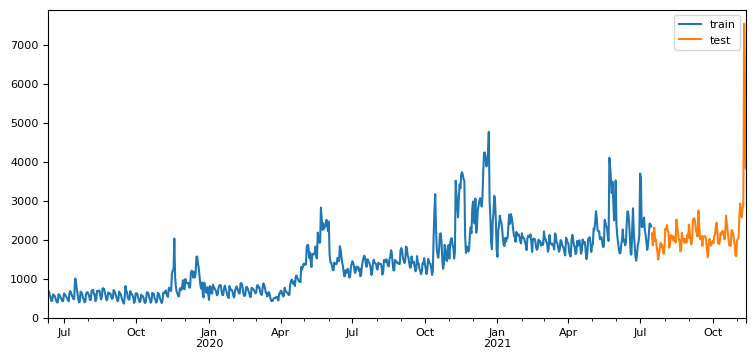

In [103]:
steps = 120
data_train = df_3[:-steps]
data_test  = df_3[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['UNITS_SOLD'].plot(ax=ax, label='train')
data_test['UNITS_SOLD'].plot(ax=ax, label='test')
ax.legend();

In [117]:
SARIMAmodel = SARIMAX(data_train, order = (1, 1, 0), seasonal_order=(1,1,0,180)) 
SARIMAmodel = SARIMAmodel.fit()

In [118]:
y_pred = SARIMAmodel.get_forecast(len(data_test.index)+21)
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred = SARIMAmodel.get_forecast(len(data_test.index)+21)
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1]+ timedelta(days=21))
#y_pred_df.index = data_test.index
y_pred_out = y_pred_df["Predictions"]

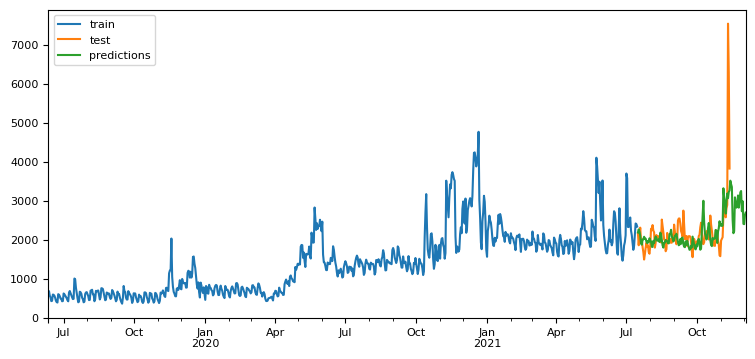

In [119]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train['UNITS_SOLD'].plot(ax=ax, label='train')
data_test['UNITS_SOLD'].plot(ax=ax, label='test')
y_pred_out.plot(ax=ax, label='predictions')
ax.legend();

In [120]:
arma_rmse = np.sqrt(mean_squared_error(data_test["UNITS_SOLD"].values, y_pred_df[y_pred_df.index.isin(data_test.index)]["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  601.9649168532607
